# Домашнее задание 3

__Дедлайн: 17.11.2022, 23:59__

Файлы должны иметь имя HW1_ФАМИЛИЯ.ipynb, где ФАМИЛИЯ - Ваша фамилия русскими буквами. 

Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться **без ошибок**. 

Во всех задачах, где требуется сравнить методы, требуется аккуратное офрмление графиков, если Вы их будете строить, и комментарии к графикам (кто кого быстрее и когда сходится, какие интересные моменты Вы видите на графиках, как Вы их можете объяснить). Аналогично, требуются комментарии в случае, если Вы сравниваете время работы.

Задачи со звездочкой не являются обязательными к решению, но за них будут даны бонусные баллы.

Суммарное количество баллов: 31

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
sns.set_theme()

## Задача 1. Линейная регрессия [9]

Рассмотрим задачу линейной регресии с $\ell_2$ регуляризатором:

$$\min_{w\in\mathbb{R}^n} \frac{1}{2}\|Xw-y\|^2 + \frac{\lambda}{2}\|w\|^2,$$
где $X\in\mathbb{R}^{m\times n}, y\in\mathbb{R}^m, \lambda \in \mathbb{R}_+$ - параметры задачи. В данном упражнении мы изучим эффективность метода сопряженных градиентов в сравнении с прямыми методами в зависимости от структуры данных $X$. Рассмотрим три вида данных:

* $X$ не имеет специальной структуры, $m > n$ (файл `data/task1/X.npy`)
* $X$ есть разреженная матрица, $m=n$ (файл `data/task1/X_sparse.npy`)
* $X$ не имеет специальной структуры, но $m \ll n$ (файл `data/task1/X_low_rank.npy`)

Таргеты $y$ берутся из файлов `data/task1/y*.npy` с соответсвующим именем. Коэффициент $\lambda$ во всех случаях возьмем равным $10^{-1}$.

1. [2] Выпишите явно решение для задачи линейной регресии. Реализуйте функцию, которая принимает на вход $X$, $y$ и $w$ возвращает решение (рекомендуется использовать функцию `np.linalg.solve`, а не `np.linalg.inv` в этом задании)

2. [1] Сравните два способа вычисления решения по времени:
    * Явное вычисление решение методом из пункта 1
    * Использование метода сопряженных градиентов с критерием останова $\|\nabla f(x)\|\leq \varepsilon=10^{-6}$.

3. [2] Реализуйте эффективно метод сопряженных градиентов для разреженной матрицы. Проведите такое же сравнение, как в пункте 2.

4. [3] Реализуйте эффективно метод сопряженных градиентов для матрицы без структуры, но с $m \ll n$. Проведите такое же сравнение, как в пункте 2.

5. [1] Исходя из того, что для точки выхода верно $\|\nabla f(x)\|\leq \varepsilon=10^{-6}$, дайте оценку на величину $f(x)-f^*$. 

*Hint:* Необязательно переписывать код метода под каждую отдельную матрицу. Достаточно передать матрицу A правильного класса. Также полезным для третьего пункта может оказаться модуль `scipy.sparse`.

### Решение задачи 1: 

In [2]:
X = np.load('data/task1/X.npy')
y = np.load('data/task1/y.npy')

Выпишем явное решение для задачи линейной регрессии:
$$ \nabla_w F = X^TXw - X^Ty + \lambda w = X^T(Xw - y) + \lambda w = (X^TX + \lambda I_n)w - X^Ty = 0$$
$$ \widehat{w} = (X^TX + \lambda I_n)^{-1}X^T y$$

In [3]:
def analytic_lreg(X, y, alpha):
    start = time.time()
    A = X.T @ X + np.eye(X.shape[1]) * alpha
    b = X.T @ y
    solution = np.linalg.solve(A, b)
    return solution, time.time() - start

In [4]:
class ConjugateGradientQuadratic:
    def __init__(self, A, b, return_history=True, name=None):
        self.name = name
        self.A, self.b = A.astype(np.float64), b.astype(np.float64)
        self.return_history = return_history
        self.history = []

    def gradf(self, x):
        return self.A @ x - self.b
        
    def solve(self, x0, tol=1e-3, max_iter=10000):
        A, b = self.A, self.b
        self.history = [(0, 0)]
        x = x0.copy()
        k = 0
        r = self.gradf(x)
        p = -r
        norm = np.linalg.norm(self.gradf(x))
        while k == 0 or norm > tol:
            start = time.time()
            alpha = r.dot(r) / p.dot(A.dot(p))
            x = x + alpha * p
            r_next = r + alpha * A.dot(p)
            beta = r_next.dot(r_next) / r.dot(r)
            p = -r_next + beta * p
            r = r_next
            norm = np.linalg.norm(self.gradf(x))
            if self.return_history:
                self.history.append((norm, time.time() - start))
            if k >= max_iter:
                break
            k += 1
        return x

In [5]:
alpha = 0.1
A = X.T @ X + np.eye(X.shape[1]) * alpha
b = X.T @ y
eps = 1e-6

CG = ConjugateGradientQuadratic(A, b)
CG.solve(np.zeros(X.shape[1]), eps)
sol, analytic_time = analytic_lreg(X, y, alpha)

In [6]:
def plot_results(cg_history, analytic_time):
    fig = plt.figure(figsize=(12, 7))
    plt.plot(cg_history[:, 1].cumsum(), cg_history[:, 0], label='CG solution', color='green')
    plt.axvline(analytic_time, cg_history[:, 0].min(), cg_history[:, 0].max(), label='analytic solution', color='red')
    plt.xlabel('Время')
    plt.ylabel('Норма градиента')
    plt.yscale('log')
    plt.legend()

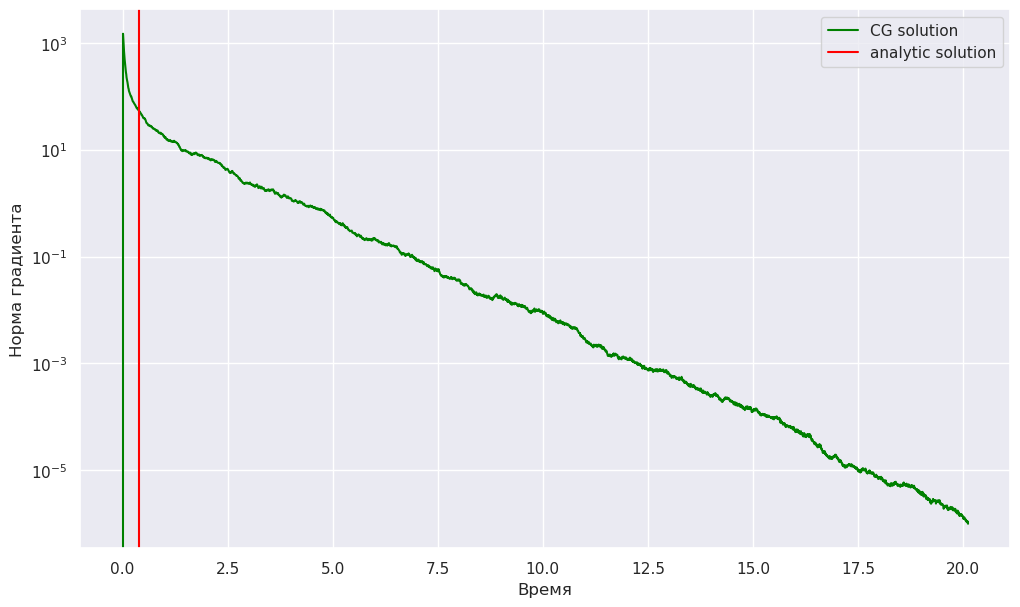

In [7]:
cg_history = np.array(CG.history)
plot_results(cg_history, analytic_time)

Как можно заметить, на обычной матрице аналитический способ намного лучше, т.к. метод сопряжённых градиентов сходится очень медленно. Посмотрим теперь на случай разреженной матрицы:

In [8]:
from scipy.sparse import csr_matrix

In [9]:
X_sparse = np.load('data/task1/X_sparse.npy')
y_sparse = np.load('data/task1/y_sparse.npy')

In [10]:
alpha = 0.1
A = csr_matrix(X_sparse.T @ X_sparse + np.eye(X_sparse.shape[1]) * alpha)
b = X_sparse.T @ y_sparse
eps = 1e-6

CG = ConjugateGradientQuadratic(A, b)
CG.solve(np.zeros(X_sparse.shape[1]), eps)
sol, analytic_time = analytic_lreg(X_sparse, y_sparse, alpha)

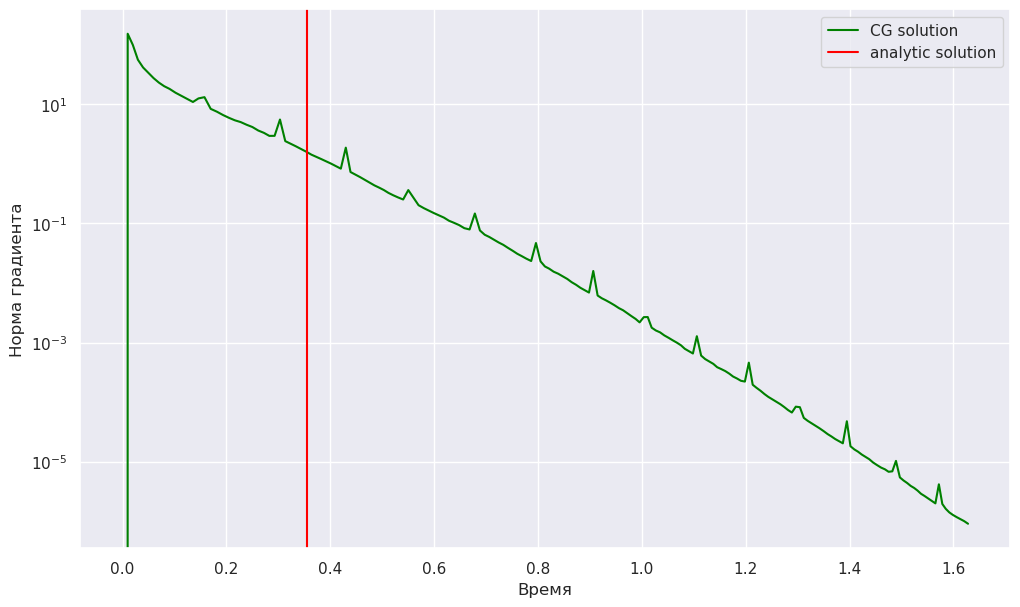

In [11]:
cg_history = np.array(CG.history)
plot_results(cg_history, analytic_time)

Уже чуть лучше, но всё равно CG сходится сильно медленее, чем аналитический способ.

Теперь напишем для случай матриц с малым рангом - эффективно реализовать умножение такиц матриц можно с помощью SVD-разложения: матрица сингулярных значений будет иметь на главной диагонали немного ненулевых значений (их количество определяется рангом матрицы), поэтому можно редуцировать умножение, используя этот факт - вместо асимптотики $ O(nm)$ можно получить $O(r(n + m))$, где $r$ - ранг матрицы, что значительно лучше, учитывая, что $m$ сильно меньше $n$

In [12]:
class ConjugateGradientQuadraticLowRank:
    def __init__(self, A, b, alpha, return_history=True, name=None):
        self.name = name
        self.A, self.b = A.astype(np.float64), b.astype(np.float64)
        self.return_history = return_history
        self.history = []

    def gradf(self, x):
        
        return self.A_l @ (self.A_r @ x) - self.b
        
    def solve(self, x0, tol=1e-3, max_iter=10000):
        A, b = self.A, self.b
        U, S, V = np.linalg.svd(A)
        rank = (np.abs(S) > 1e-15).sum()
        
        self.A_l = (U[:, :rank] * S[:rank])
        self.A_r = V[:rank, :]
        self.history = [(0, 0)]
        x = x0.copy()
        k = 0
        r = self.gradf(x)
        p = -r
        
        #U_reduced, S_reduced, V_reduced = U[:, :rank], S[:rank], V[:rank, :]
        A_red = self.A_l @ (self.A_r @ p)
        norm = np.linalg.norm(r)
        while k == 0 or norm > tol:
            start = time.time()
            alpha = r.dot(r) / p.dot(A_red)
            x = x + alpha * p
            r_next = r + alpha * (A_red)
            beta = r_next.dot(r_next) / r.dot(r)
            p = -r_next + beta * p
            A_red = self.A_l @ (self.A_r @ p)
            r = r_next
            norm = np.linalg.norm(self.gradf(x))
            if self.return_history:
                self.history.append((norm, time.time() - start))
            if k >= max_iter:
                break
            k += 1
        return x

In [13]:
X_low_rank = np.load('data/task1/X_low_rank.npy')
y_low_rank = np.load('data/task1/y_low_rank.npy')

In [14]:
alpha = 0.1
A = X_low_rank.T @ X_low_rank + np.eye(X_low_rank.shape[1]) * alpha
b = X_low_rank.T @ y_low_rank
eps = 1e-6

CG = ConjugateGradientQuadraticLowRank(A, b, alpha)
CG.solve(np.zeros(X_low_rank.shape[1]), eps)
sol, analytic_time = analytic_lreg(X_low_rank, y_low_rank, alpha)

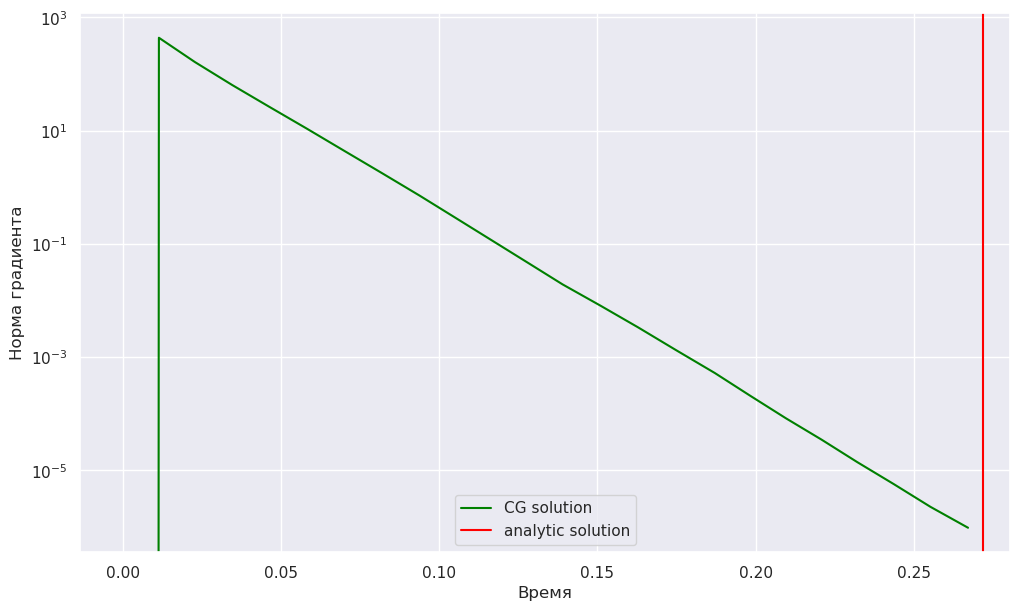

In [15]:
cg_history = np.array(CG.history)
plot_results(cg_history, analytic_time)

Как можно видеть, на матрицах с маленьким рангом метод сопряжённых градиентов уже выигрывает у аналитического решения по времени и не сильно проигрывает по норме.

## Задача 2. Сравнение методов [17]

Пусть есть некоторый временной ряд $x_1^\text{init} \dots x_n^\text{init}$. Вектор с соответвующими компонентами обозначим, как $\mathbf{x}^\text{init}$. Мы наблюдаем некоторый поврежденный сигнал $\mathbf{y}=f(\mathbf{x}^\text{init})$. Если предположить, что исходный сигнал был достаточно гладким, то можно ожидать, что повреждения подпортили эту гладкость. Один из способов востановить исходный сигнал - найти "гладкий" сигнал, "близкий" к наблюдаемому:

$$\psi(\mathbf{x}-\mathbf{y}) + \lambda\phi(\mathbf{x}) \rightarrow \min_{x\in\mathbf{R}^n} \qquad\qquad (1)$$
где $\psi$ - функция штрафа для сильно удаленных примеров, $\phi$ - сглаживающий регуляризатор.

Во всех пунктах используется $\psi(\mathbf{x})=\|\mathbf{x}\|_2^2$. В пунктах 1-6 используется функция сглаживания $\phi(\mathbf{x})=\frac{1}{2}\sum\limits_{j=2}^n (x_j-x_{j-1})^2.$ В пункте 8 используется функция $\phi(\mathbf{x})=\sum\limits_{j=2}^n\left(\sqrt{\varepsilon^2+(x_{j}-x_{j-1})^2}-\varepsilon\right)$. Параметр сглаживания $\lambda$ в пунктах 1-5 возьмите равным 15, в пунктах 6-8 -- 5.

0. [1] Реализуйте вычисление целевой функции и её градиента.

1. [1] К чему стремится решение этой задачи при $\lambda\rightarrow 0$? А при $\lambda\rightarrow\infty$? Чему равны константы Липшица градиента $L$ и константа сильной выпуклости $\mu$? Как зависит число обусловленности задачи от $\lambda$?

2. [2] Реализуйте поиск шага, удовлетворяющего условиям Гольдштейна

3. [1] Сравните градиентный спуск с различными адаптивными стратегиями (Армихо, Вольф, Гольдштейн) и выберите наилучший. Используйте параметры $\rho=\frac{1}{2}, \beta_1=0.3, \beta_2=0.9$ или бликие к ним.

4. [1] Реализуйте наискорейший спуск

5. [3] Сравните по итерациям и по времени следующие методы

    * Градиентный спуск с лучшей адаптивной стратегией выбора шага (пункт 3) 

    * Градиентный спуск с шагом $\frac{1}{L}$
    
    * Наискорейший спуск

    * Метод Нестерова с оптимальным шагом

    * Метод тяжелого шарика с оптимальным шагом

    * Метод сопряженных градиентов
    
   Сделайте выводы.
   
Далее будем рассматривать задачу с регуляризатором вида $\phi(\mathbf{x})=\sum\limits_{j=2}^n\left(\sqrt{\varepsilon^2+(x_{j}-x_{j-1})^2}-\varepsilon\right)$ для $\varepsilon=0.001$.
6. [2] Реализуйте метод Хестенса-Штифеля (HS) с рестартами

7. [2] Добавьте во все методы возможность использования условия рестартов, основанное на коллинеарности градиентов на соседних итерациях

8. [1] Подберите как можно лучшее условие рестарта для методов FR, PR и HS. Шаг выбирайте при помощи правила Вольфа

9. [2] Сравните методы FR, PR и HS с предыдущей итерации для задачи выше.

10. [1] Нарисуйте исходный сигнал (`data/task2/x_init.npy`) и сигналы востановленные в пунктах 5 и 8.

### Решение задачи 2: 

Сделаем нулевой пункт:

In [16]:
def f(x, lambd=15):
    psi = np.linalg.norm(x - y) ** 2
    phi = 1 / 2 * np.sum((x[1:] - x[:-1]) ** 2)
    return psi + phi * lambd

def grad_f(x, lambd=15):
    grad_psi = 2 * (x - y)
    grad_phi = 2 * x - np.hstack([0, x[1:]]) - np.hstack([x[:-1], 0])
    return grad_psi + grad_phi * lambd

In [17]:
sns.set_theme(palette='Set2')

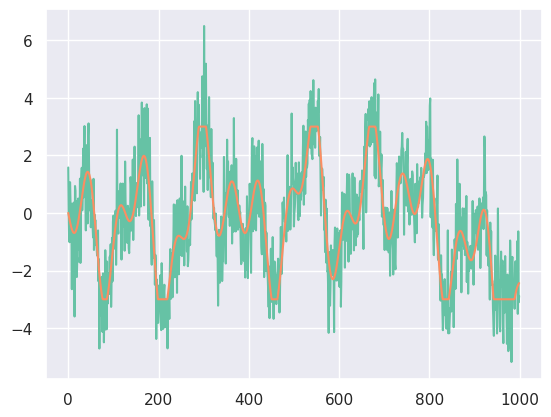

In [18]:
x_init = np.load("data/task2/x_init.npy")
y = np.load("data/task2/corrupted.npy")
y.shape, x_init.shape
plt.plot(y)
plt.plot(x_init)

При $\lambda \to 0$ решение задачи стремится к $y$. Рассмотрим теперь случай $\lambda \to \infty$: <br>
При константном $x$ регуляризация зануляется, а минимум функции сглаживания достигается в $x = \bar{y}$. <br>
$$\nabla \psi (x - y) = 2(x - y), \nabla \nabla \psi = \text{diag}(2)
\\
\frac{\partial \phi}{\partial x_1} = x_1 - x_2, \frac{\partial \phi}{\partial x_n} = x_n - x_{n-1}
$$ В остальных случаях:
$$
\frac{\partial \phi}{\partial x_i} = 2x_i - (x_{i-1} - x_{i+1})
$$ и, наконец, 
$
\nabla \nabla \phi$ - такая матрица, что на диагонали стоят $1, 2, ..., 2, 1$, а на соседних с главной диагональю стоят $-1$.  

In [19]:
lambd = 15
psi = 2 * np.eye(y.shape[0])
phi = psi + np.diag([-1] + [0] * (y.shape[0] - 2) + [-1]) + np.diag([-1] * (y.shape[0] - 1), 1) + np.diag([-1] * (y.shape[0] - 1), -1)
phi

array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [20]:
eigs = np.linalg.eigvals(psi + lambd * phi)
eigs.min(), eigs.max()

(2.0, 61.999851956055444)

Итого: $2$ - константа сильной выпуклости, $62$ - константа Липшица.

In [21]:
class StepSize:
    def __call__(self, x, h, k, *args, **kwargs):
        pass
    
class ConstantStepSize(StepSize):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha
    
class SeqStepSize(StepSize):
    def __init__(self, d=1, alpha0=1, alpha_function=None):
        if alpha_function is not None:
            self.alpha_function = alpha_function
        else:
            self.alpha_function = lambda k: alpha0/(k+1)**d
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha_function(k)
    

class Armijo(StepSize):
    def __init__(self, beta=0.3, rho=0.1, alpha0=1):
        self.beta = beta
        self.rho = rho
        self.alpha0 = alpha0
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        beta, rho, alpha = self.beta, self.rho, self.alpha0
        fx = f(x)
        hg = h.dot(gradf(x))    
        while f(x + alpha * h) > fx + beta * alpha * hg:
            alpha *= rho
        return alpha
    
class Wolfe(StepSize):
    def __init__(self, beta1=0.3, beta2=0.9, rho1=0.1, rho2=2, alpha0=1):
        self.beta1, self.beta2 = beta1, beta2
        self.rho1, self.rho2 = rho1, rho2
        self.alpha0 = alpha0
    
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        beta1, rho1, alpha = self.beta1, self.rho1, self.alpha0
        beta2, rho2 = self.beta2, self.rho2
        lb, ub = 0, np.inf
        fx = f(x)
        g = gradf(x)
        hg = h.dot(g)
        while True:
            x_new = x + alpha * h
            if f(x_new) > fx + beta1 * alpha * hg:
                ub = alpha
                alpha = 1/2 * (lb + ub)
            elif gradf(x_new).dot(h) < beta2 * hg:
                lb = alpha
                if np.isinf(ub):
                    alpha = 2 * lb
                else:
                    alpha = 0.5 * (lb + ub)
            else:
                return alpha
            if ub - lb <= 1e-12:
                return alpha
            
class Goldstein(StepSize):
    def __init__(self, beta1, beta2):
        self.beta1, self.beta2 = beta1, beta2
        
    def __call__(self, x, h, k, grad_f, f, *args, **kwargs):
        beta1, beta2 = self.beta1, self.beta2
        l = 0
        r = 2 ** 10 - 1
        scalar = grad_f(x).dot(h)
        
        while True:
            m = (l + r) / 2
            if f(x + m * h) > f(x) + beta1 * m * scalar:
                r = m
            elif f(x + m * h) < f(x) + beta2 * m * scalar:
                l = m
            else:
                break
        
        return m

In [22]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        start = time.time()
        x = x0.copy()
        k = 0
        x_prev = None
        norm = np.linalg.norm(gradf(x))
        self.history = [(norm, 0)]
        while x_prev is None or norm > tol: 
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            norm = np.linalg.norm(gradf(x))
            if self.return_history:
                self.history.append((norm, time.time() - start))
            if k >= max_iter:
                break
            k += 1
        return x

In [23]:
rho  = 0.5
beta1 = 0.3 
beta2 = 0.9
x0 = np.zeros(y.shape)

armijo = GradientDescent(Armijo(beta=beta1, rho=rho))
wolfe = GradientDescent(Wolfe(beta1=beta1, beta2=beta2, rho1=rho, rho2=rho))
goldstein = GradientDescent(Goldstein(beta1=beta1, beta2=beta2))

labels = ['armijo', 'wolfe', 'goldstein']
methods = [armijo, wolfe, goldstein]
results = {}
for method, label in zip(methods, labels):
    method.solve(x0=x0, f=f, gradf=grad_f)
    results[label] = method.history

In [24]:
def plot_methods(results):
    plt.figure(figsize=(12, 7))
    for label, res in results.items():
        np_res = np.array(results[label])
        plt.plot(np_res[:, 1], np_res[:, 0], label=label)
    
    plt.xlabel('Время')
    plt.ylabel('Норма градиента')
    #plt.yscale('log')
    plt.xlim((0, 0.01))
    plt.legend()

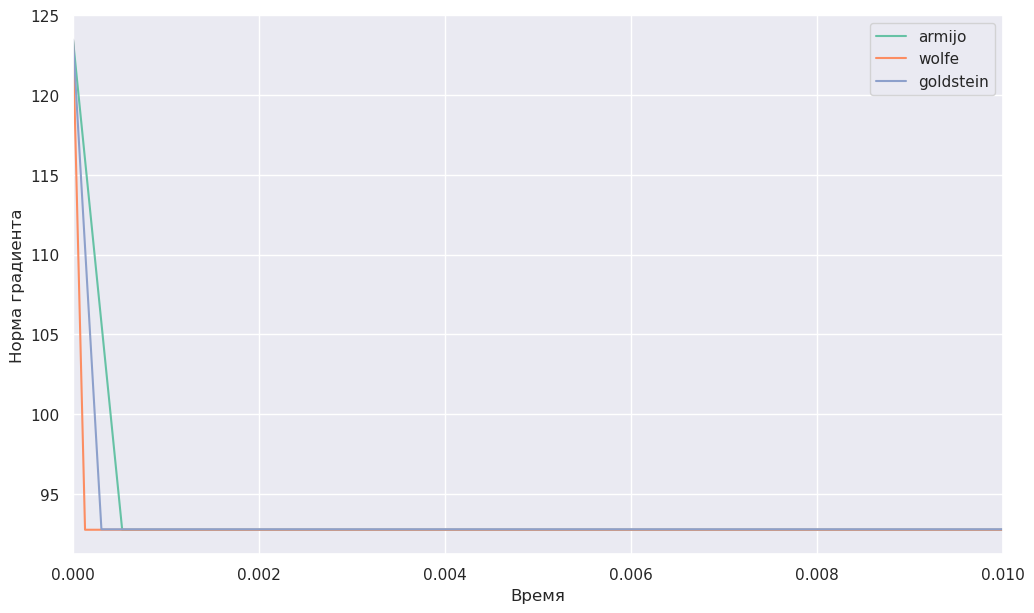

In [25]:
plot_methods(results)

Все методы "зависли" в одном и том же месте, но `Wolfe` оказался быстрее всех (хотя разница во времени небольшая).


Реализуем теперь наискорейший спуск и сравнение методов:

In [26]:
from scipy.optimize import minimize_scalar

class Steepest(StepSize):
    def __init__(self):
        pass 

    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        step = minimize_scalar(lambda alpha: f(x + alpha *h))
        return step.x
    
class ConstStep(StepSize):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha
    
class CG_FR:
    def __init__(self, StepSizeChoice, restart=False, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.restart = restart
    
    def solve(self, x0, f, gradf, tol=1e-3, g_tol=1e-3, max_iter=10000):
        start = time.time()
        x = x0.copy()
        k = 0
        grad = gradf(x)
        p = -grad
        self.history = [(np.linalg.norm(gradf(x)), 0)]
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            alpha = self.StepSizeChoice(x, p, k, gradf, f)
            if alpha < 1e-18:
                break
            x = x + alpha * p
            grad_next = gradf(x)
            beta = grad_next.dot(grad_next) / grad.dot(grad)
            p = -grad_next + beta * p
            k += 1
            if self.restart and k % self.restart == 0:
                grad = gradf(x)
                p = -grad
            if self.return_history:
                self.history.append((np.linalg.norm(gradf(x)), time.time() - start))
            if k >= max_iter:
                break
        return x

    
class CG_PR:
    def __init__(self, StepSizeChoice, restart=False, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.restart = restart
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        start = time.time()
        x = x0.copy()
        k = 0
        grad = gradf(x)
        p = -grad
        self.history = [(np.linalg.norm(gradf(x)), 0)]
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            alpha = self.StepSizeChoice(x, p, k, gradf, f)
            if alpha < 1e-18:
                break
            x = x + alpha * p
            grad_next = gradf(x)
            beta = grad_next.dot(grad_next-grad) / grad.dot(grad)
            p = -grad_next + beta * p
            grad = grad_next.copy()
            k += 1
            if self.restart and k % self.restart == 0:
                grad = gradf(x)
                p = -grad
            if self.return_history:
                self.history.append((np.linalg.norm(gradf(x)), time.time() - start))
            if k >= max_iter:
                break
        return x


class HeavyBall:
    def __init__(self, alpha=None, beta=None, L=None, mu=None, return_history=True, name=None):
        self.name = name
        if alpha is not None and beta is not None:
            self.alpha = alpha
            self.beta = beta
        else:
            self.alpha, self.beta = self.get_alpha_beta(L, mu)
        self.return_history = return_history
    
    @staticmethod
    def get_alpha_beta(L, mu):
        alpha = 4 / (np.sqrt(L) + np.sqrt(mu))**2
        beta1 = (1 - np.sqrt(alpha * L))**2
        beta2 = (1 - np.sqrt(alpha * mu))**2
        beta = max(beta1, beta2)
        return alpha, beta
        
    
    def __call__(self, x0, f, gradf, N):
        self.history = [(x0, time.time())]
        alpha, beta = self.alpha, self.beta
        x = x0.copy()
        x_prev = x0.copy()
        for k in range(N):
            g = gradf(x)
            x_prev, x = x, x - alpha * g + beta * (x - x_prev)
            if self.return_history:
                self.history.append((x, time.time()))
        return x
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        start = time.time()
        alpha, beta = self.alpha, self.beta
        x = x0.copy()
        k = 0
        x_prev = x0.copy()
        self.history = [(np.linalg.norm(gradf(x)), 0)]
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            g = gradf(x)
            x_prev, x = x, x - alpha * g + beta * (x - x_prev)
            if self.return_history:
                self.history.append((np.linalg.norm(gradf(x)), time.time() - start))
            if k >= max_iter:
                break
            k += 1
        return x
    

class Nesterov:
    def __init__(self, alpha=None, return_history=True, name=None):
        self.name = name
        self.alpha = alpha
        self.return_history = return_history
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        start = time.time()
        alpha = self.alpha
        x = x0.copy()
        k = 0
        x = x0.copy()
        x_prev = x0.copy()
        y = x0.copy()
        self.history = [(np.linalg.norm(gradf(x)), 0)]
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            x_prev, x = x, y - alpha * gradf(y)
            y = x + k/(k+3) * (x - x_prev)
            if self.return_history:
                self.history.append((np.linalg.norm(gradf(x)), time.time() - start))
            if k >= max_iter:
                break
            k += 1
        return x

In [27]:
L = 62
mu = 2

solvers = [
    GradientDescent(Armijo(rho=rho, beta=beta1)),
    GradientDescent(Wolfe(beta1=beta1, beta2=beta2, rho1=rho, rho2=rho)),
    GradientDescent(Goldstein(beta1=beta1, beta2=beta2)), 
    GradientDescent(ConstStep(alpha=1/L)),
    GradientDescent(Steepest()),
    HeavyBall(L=L, mu=mu),
    Nesterov(4 / (3*L+mu)),
    CG_FR(Wolfe(beta1=beta1, beta2=beta2)),
    CG_PR(Wolfe(beta1=beta1, beta2=beta2))
]

labels = ['GD Armijo', 'GD Wolfe', 'GD Goldstein', 'GD ConstStep', 'GD Steepest', 'HeavyBall',
         'Nesterov', 'CG_FR', 'CG_PR']

results = {}
for solver, label in zip(solvers, labels):
    solver.solve(x0=y, f=f, gradf=grad_f, max_iter=1000)
    results[label] = solver.history

In [28]:
def plot_methods(results):
    plt.figure(figsize=(12, 7))
    for label, res in results.items():
        np_res = np.array(results[label])
        plt.subplot(2, 1, 1)
        plt.plot(np_res[:, 1], np_res[:, 0], label=label)
        plt.xlabel('Время')
        plt.yscale('log')
        plt.xlim((0, 0.005))
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(np.arange(1, np_res[:, 1].shape[0] + 1), np_res[:, 0], label=label)
        plt.xlabel('Итерация')
        plt.xlim((0, 100))
        plt.yscale('log')
        plt.legend()
    
    plt.ylabel('Норма градиента')

In [29]:
sns.set_theme(palette='bright')

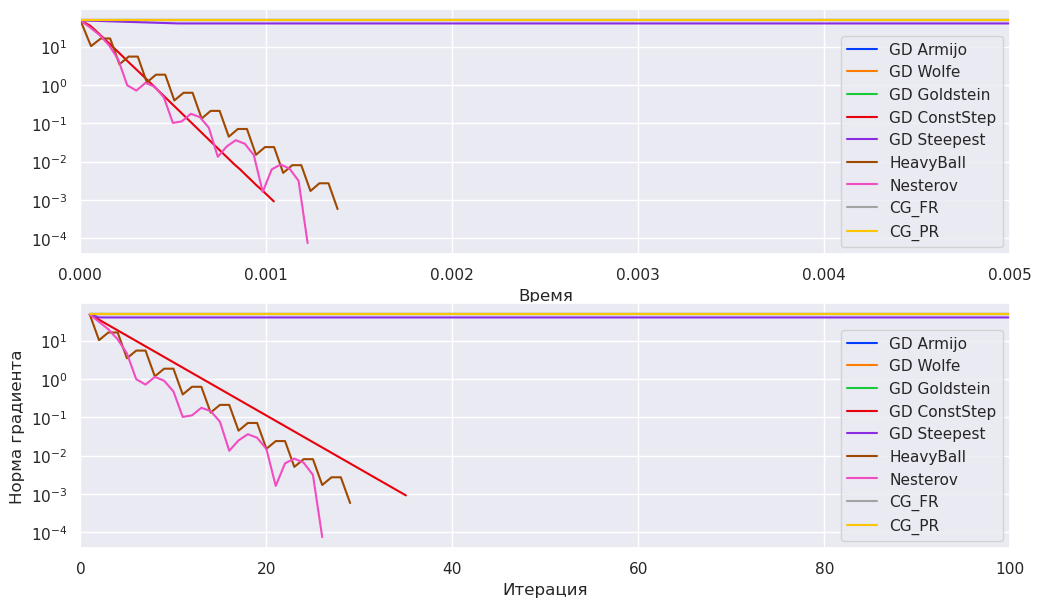

In [30]:
plot_methods(results)

Как можно видеть, эффективнее всего оказался метод Нестерова. Близки к нему HeavyBall и градиентный спуск с постоянным шагом, остальные же методы GD с кастомным поиском шага достаточно быстро затухли, а методы сопряжённых градиентов не смогли дать свою эффективность для неквадратичной функции.

Реализуем теперь новую функцию, HS и рестарты во всех методах:

In [31]:
def f_eps(x, lambd = 5, eps = 1e-3):
    psi = np.linalg.norm(x - y) ** 2
    phi = np.sum(np.sqrt(eps ** 2 + (x[1:] - x[:-1]) ** 2) - eps)
    return psi + lambd * phi

def grad_f_eps(x, lambd = 5, eps = 1e-3):
    grad_psi = 2 * (x - y)
    grad_phi = (x[1:] - x[:-1]) / np.sqrt(eps ** 2 + (x[1:] - x[:-1]) ** 2)
    grad_phi = np.hstack([0, grad_phi]) - np.hstack([grad_phi, 0])
    return grad_psi + grad_phi * lambd

In [32]:
def collinearity(v1, v2, tol):
    return np.abs(v1.dot(v2) / v2.dot(v2)) > tol

class CG_HS:
    def __init__(self, StepSizeChoice, restart=False, grad_restart=False, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.restart = restart
        self.grad_restart = grad_restart
        self.history = []
    
    def solve(self, x0, f, gradf, tol=1e-3, g_tol = 1e-3, max_iter=10000):
        start = time.time()
        x = x0.copy()
        k = 0
        grad = gradf(x)
        p = -grad
        norm = np.linalg.norm(grad)
        self.history = [(norm, 0)]
        while k == 0 or norm > tol: 
            alpha = self.StepSizeChoice(x, p, k, gradf, f)
            if alpha < 1e-18:
                break
            x = x + alpha * p
            grad_next = gradf(x)
            beta = grad_next.dot(grad_next-grad) / p.dot(grad_next - grad)
            p = -grad_next + beta * p
            
            if self.grad_restart and collinearity(grad, grad_next, g_tol):
                grad = gradf(x)
                p = -grad
            else:
                grad = grad_next.copy()
            
            k += 1
            if self.restart and k % self.restart == 0:
                grad = gradf(x)
                p = -grad
            norm = np.linalg.norm(gradf(x))
            if self.return_history:
                self.history.append((norm, time.time() - start))
            if k >= max_iter:
                break
        return x

class CG_FR:
    def __init__(self, StepSizeChoice, restart=False, grad_restart=False, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.restart = restart
        self.grad_restart = grad_restart
    
    def solve(self, x0, f, gradf, tol=1e-3, g_tol=1e-3, max_iter=10000):
        start = time.time()
        x = x0.copy()
        k = 0
        grad = gradf(x)
        p = -grad
        self.history = [(np.linalg.norm(gradf(x)), 0)]
        while k == 0 or np.linalg.norm(gradf(x)) > tol: 
            alpha = self.StepSizeChoice(x, p, k, gradf, f)
            if alpha < 1e-18:
                break
            x = x + alpha * p
            grad_next = gradf(x)
            beta = grad_next.dot(grad_next) / grad.dot(grad)
            p = -grad_next + beta * p
            if self.grad_restart and collinearity(grad, grad_next, g_tol):
                grad = gradf(x)
                p = -grad
            else:
                grad = grad_next.copy()
            k += 1
            if self.restart and k % self.restart == 0:
                grad = gradf(x)
                p = -grad
            if self.return_history:
                self.history.append((np.linalg.norm(gradf(x)), time.time() - start))
            if k >= max_iter:
                break
        return x

    
class CG_PR:
    def __init__(self, StepSizeChoice, restart=False, grad_restart=False, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.restart = restart
        self.grad_restart = grad_restart
    
    def solve(self, x0, f, gradf, tol=1e-3, g_tol=1e-3, max_iter=10000):
        start = time.time()
        x = x0.copy()
        k = 0
        grad = gradf(x)
        p = -grad
        norm = np.linalg.norm(gradf(x))
        self.history = [(norm, 0)]
        while k == 0 or norm > tol: 
            alpha = self.StepSizeChoice(x, p, k, gradf, f)
            if alpha < 1e-18:
                break
            x = x + alpha * p
            grad_next = gradf(x)
            beta = grad_next.dot(grad_next-grad) / grad.dot(grad)
            p = -grad_next + beta * p
            if self.grad_restart and collinearity(grad, grad_next, g_tol):
                grad = gradf(x)
                p = -grad
            else:
                grad = grad_next.copy()
            k += 1
            if self.restart and k % self.restart == 0:
                grad = gradf(x)
                p = -grad
            if self.return_history:
                self.history.append((np.linalg.norm(gradf(x)), time.time() - start))
            if k >= max_iter:
                break
        return x

In [33]:
solvers = [
    CG_HS(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True),
    CG_FR(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True),
    CG_PR(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True)
]

labels = ['CG_HS', 'CG_FR', 'CG_PR']

results = {}
for solver, label in zip(solvers, labels):
    solver.solve(x0=y, f=f_eps, gradf=grad_f_eps, tol=1e-6, max_iter=10000)
    results[label] = solver.history

/tmp/ipykernel_373866/4026950401.py:27: RuntimeWarning: invalid value encountered in double_scalars
  beta = grad_next.dot(grad_next-grad) / p.dot(grad_next - grad)


In [34]:
def plot_methods(results):
    plt.figure(figsize=(12, 7))
    for label, res in results.items():
        np_res = np.array(results[label])
        plt.subplot(2, 1, 1)
        plt.plot(np_res[:, 1], np_res[:, 0], label=label)
        plt.xlabel('Время')
        plt.yscale('log')
        #plt.xlim((0, 0.005))
        plt.legend()
        plt.ylabel('Норма градиента')
        plt.subplot(2, 1, 2)
        plt.plot(np.arange(1, np_res[:, 1].shape[0] + 1), np_res[:, 0], label=label)
        plt.xlabel('Итерация')
        #plt.xlim((0, 100))
        plt.yscale('log')
        plt.legend()
        plt.ylabel('Норма градиента')

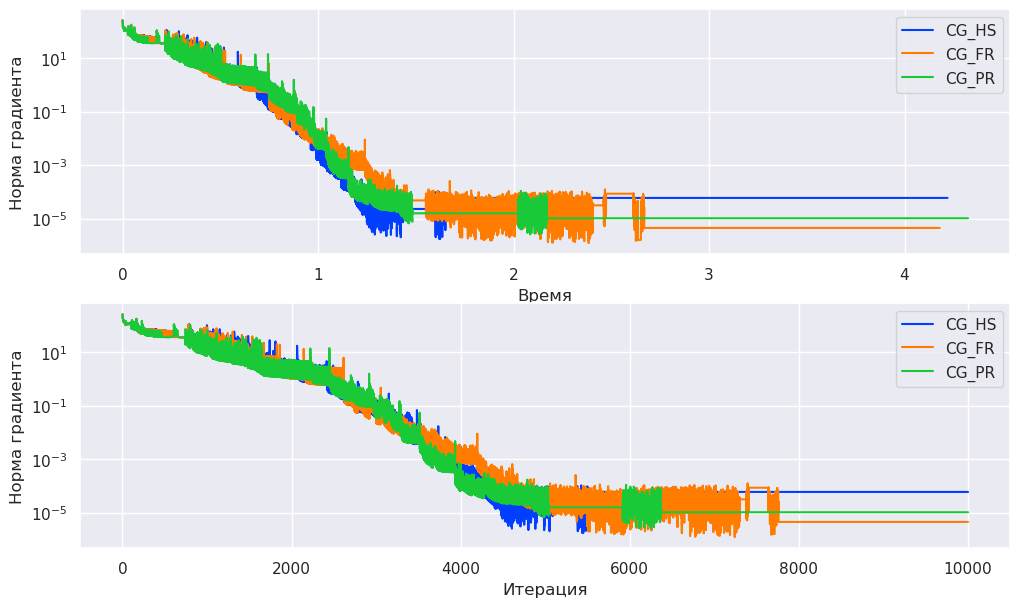

In [35]:
plot_methods(results)

Можно заметить, что в какой-то момент методы начинают прыгать возле какой-то одной точки, но до какого-то момента ещё выбираются из неё. На поздних итерациях они всё же сходятся к своему локальному минимуму.
Попробуем подобрать наилучшее условие рестарта:

In [36]:
solvers = [
    CG_HS(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True)
]

label = 'CG_HS'
tols = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
results = {'CG_HS' : []}
for g_tol in tols:
    solvers[0].solve(x0=y, f=f_eps, gradf=grad_f_eps, tol=1e-6, g_tol=g_tol, max_iter=10000)
    results[label].append(solvers[0].history)

/tmp/ipykernel_373866/4026950401.py:27: RuntimeWarning: invalid value encountered in double_scalars
  beta = grad_next.dot(grad_next-grad) / p.dot(grad_next - grad)


In [37]:
def plot_methods(results, label, tols):
    plt.figure(figsize=(14, 9))
    for i in range(len(tols)):
        np_res = np.array(results[label][i])
        plt.subplot(2, 1, 1)
        plt.plot(np_res[:, 1], np_res[:, 0], label=f'{label}, g_tol={tols[i]}')
        plt.xlabel('Время')
        plt.yscale('log')
        #plt.xlim((0, 0.005))
        plt.legend()
        plt.ylabel('Норма градиента')
        plt.subplot(2, 1, 2)
        plt.plot(np.arange(1, np_res[:, 1].shape[0] + 1), np_res[:, 0], label=f'{label}, g_tol={tols[i]}')
        plt.xlabel('Итерация')
        #plt.xlim((0, 100))
        plt.yscale('log')
        plt.legend()
        plt.ylabel('Норма градиента')

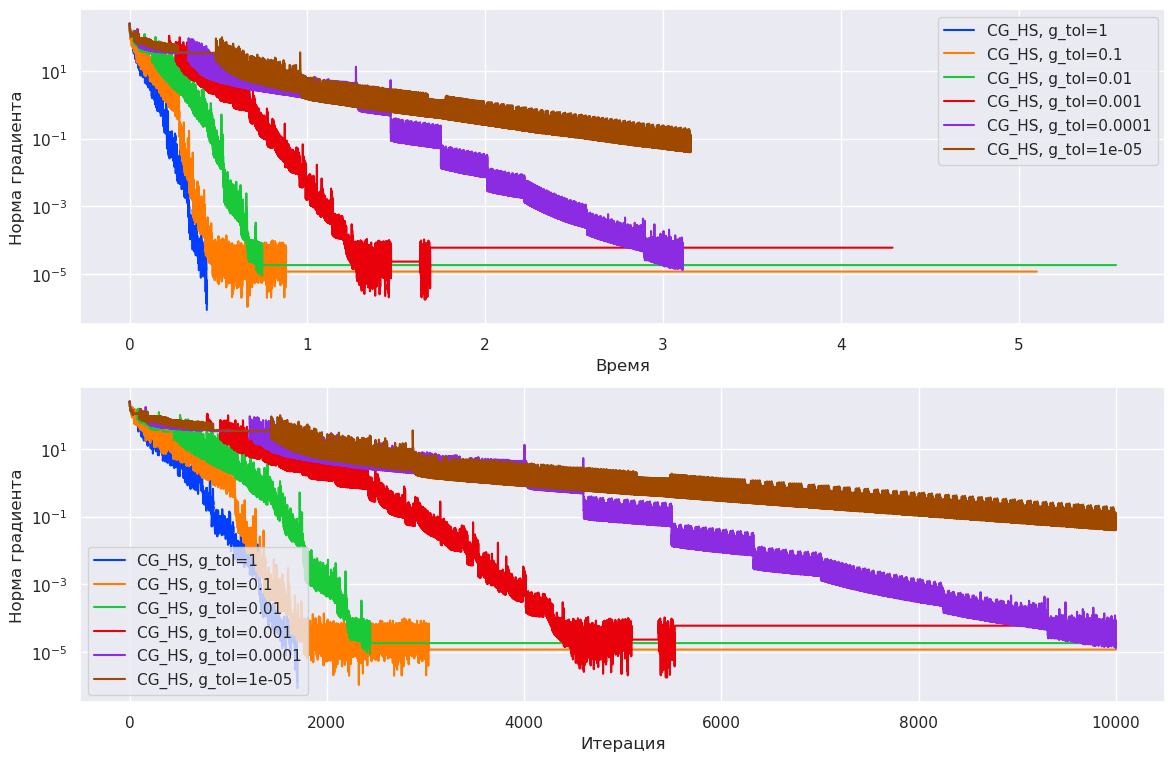

In [38]:
plot_methods(results, label, tols)

Здесь выиграл `g_tol=0.1`

In [39]:
solvers = [
    CG_FR(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True)
]

label = 'CG_FR'
tols = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
results = {'CG_FR' : []}
for g_tol in tols:
    solvers[0].solve(x0=y, f=f_eps, gradf=grad_f_eps, tol=1e-6, g_tol=g_tol, max_iter=10000)
    results[label].append(solvers[0].history)

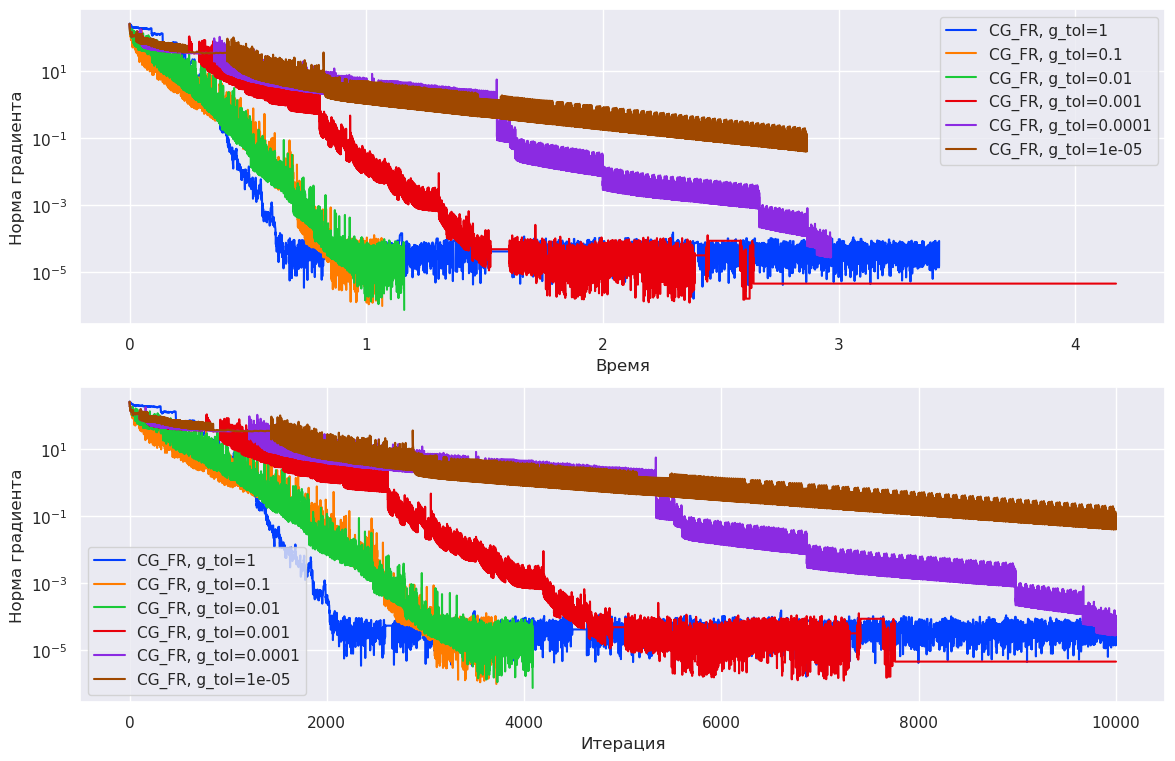

In [40]:
plot_methods(results, label, tols)

Здесь оптимально `g_tol` = 0.001

In [41]:
solvers = [
    CG_PR(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True)
]

label = 'CG_PR'
tols = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
results = {'CG_PR' : []}
for g_tol in tols:
    solvers[0].solve(x0=y, f=f_eps, gradf=grad_f_eps, tol=1e-6, g_tol=g_tol, max_iter=10000)
    results[label].append(solvers[0].history)

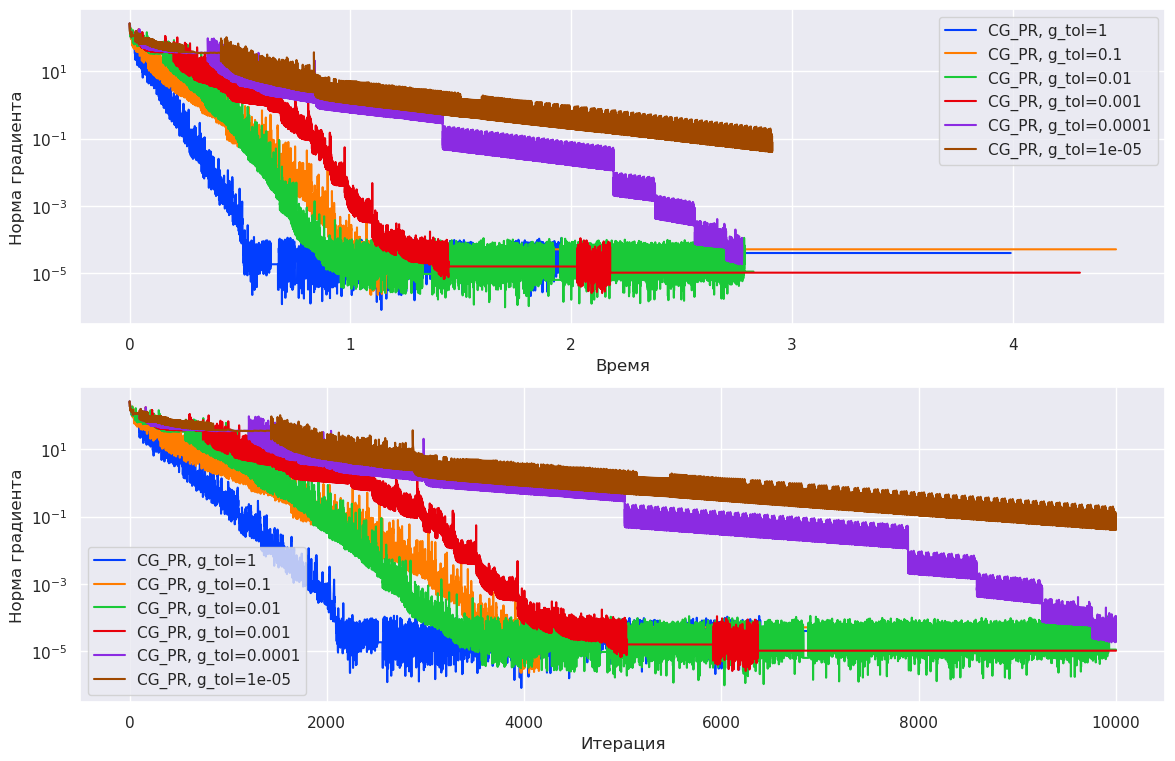

In [42]:
plot_methods(results, label, tols)

Здесь оптимально среднее между 0.01 и 0.001 - возьмём 0.0055.  Теперь сравним наши методы с найденными примерно оптимальными параметрами:

In [43]:
solvers = [
    CG_HS(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True),
    CG_FR(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True),
    CG_PR(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True)
]

labels = ['CG_HS', 'CG_FR', 'CG_PR']

results = {}
i = 0
g_tol = [0.1, 0.001, 0.0055]
for solver, label in zip(solvers, labels):
    solver.solve(x0=y, f=f_eps, gradf=grad_f_eps, tol=1e-6, g_tol=g_tol[i], max_iter=10000)
    results[label] = solver.history
    i += 1

/tmp/ipykernel_373866/4026950401.py:27: RuntimeWarning: invalid value encountered in double_scalars
  beta = grad_next.dot(grad_next-grad) / p.dot(grad_next - grad)


In [44]:
def plot_methods(results):
    plt.figure(figsize=(12, 7))
    for label, res in results.items():
        np_res = np.array(results[label])
        plt.subplot(2, 1, 1)
        plt.plot(np_res[:, 1], np_res[:, 0], label=label)
        plt.xlabel('Время')
        plt.yscale('log')
        #plt.xlim((0, 0.005))
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(np.arange(1, np_res[:, 1].shape[0] + 1), np_res[:, 0], label=label)
        plt.xlabel('Итерация')
        #plt.xlim((0, 100))
        plt.yscale('log')
        plt.legend()
    
    plt.ylabel('Норма градиента')

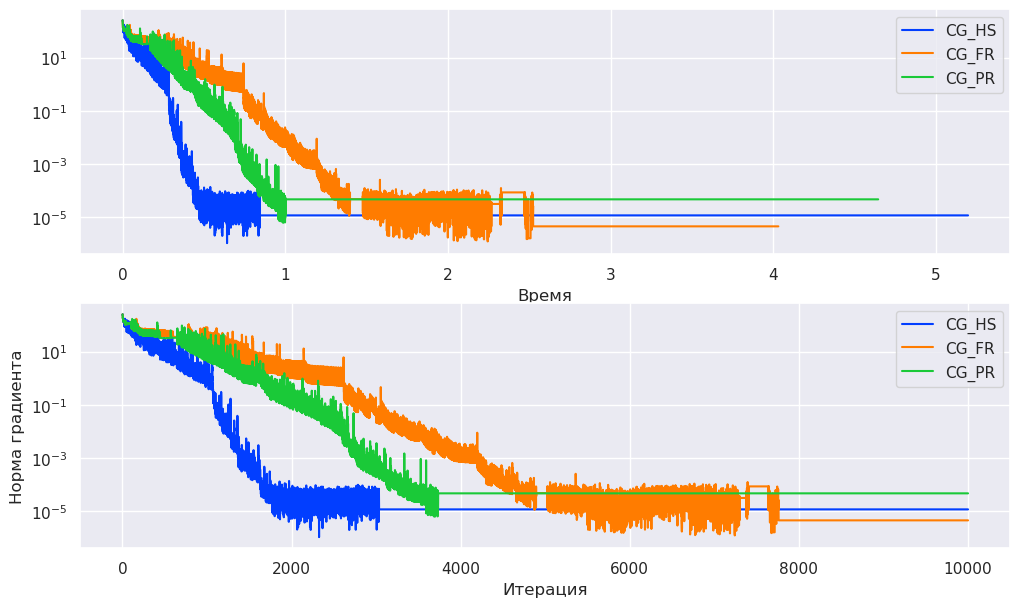

In [45]:
plot_methods(results)

CG_HS сошёлся быстрее остальных вариантов, но оказался чуть хуже, чем CG_FR. CG_PR оказался средним по скорости,  но проиграл в норму.

Нарисуем теперь восстановленные сигналы для лучших методов из пункта 5 (Нестерова) и пункта 8 (CG_FR):

In [46]:
solvers = [CG_FR(Wolfe(beta1=beta1, beta2=beta2), grad_restart=True),
          Nesterov(4 / (3*L+mu))]

names = ['CG_FR', 'Nesterov']

results = {}
signal = []
for solver, name in zip(solvers, names):
    if name == 'CG_FR':
        signal.append(solver.solve(x0=y, f=f, gradf=grad_f, tol=1e-3, g_tol=0.001, max_iter = 10000))
    else:
        signal.append(solver.solve(x0=y, f=f, gradf=grad_f, tol=1e-3, max_iter = 10000))
    results[name] = solver.history

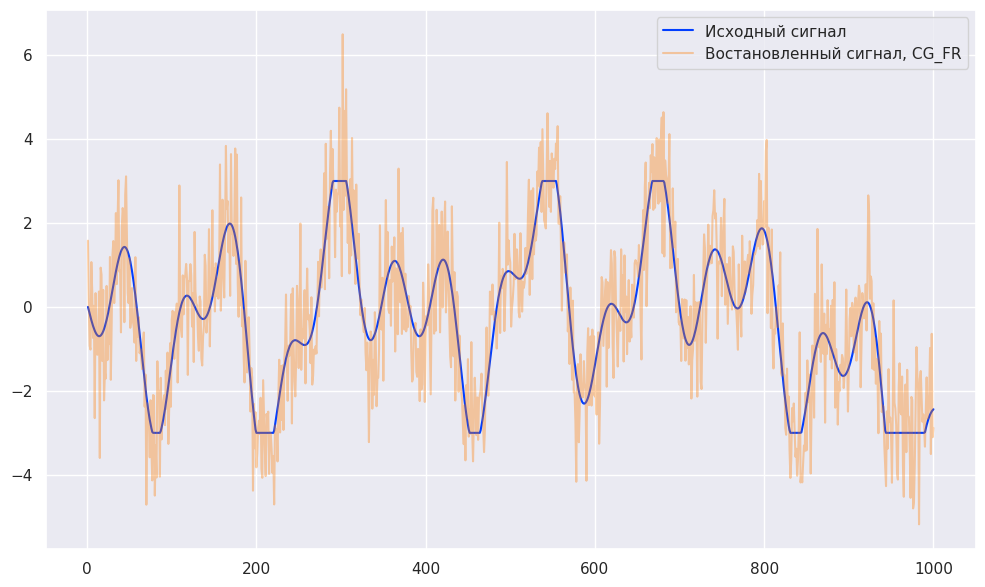

In [47]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(1, len(x_init) + 1), x_init, label='Исходный сигнал')
plt.plot(np.arange(1, len(x_init) + 1), signal[0], label='Востановленный сигнал, CG_FR', alpha=0.35)
plt.legend();

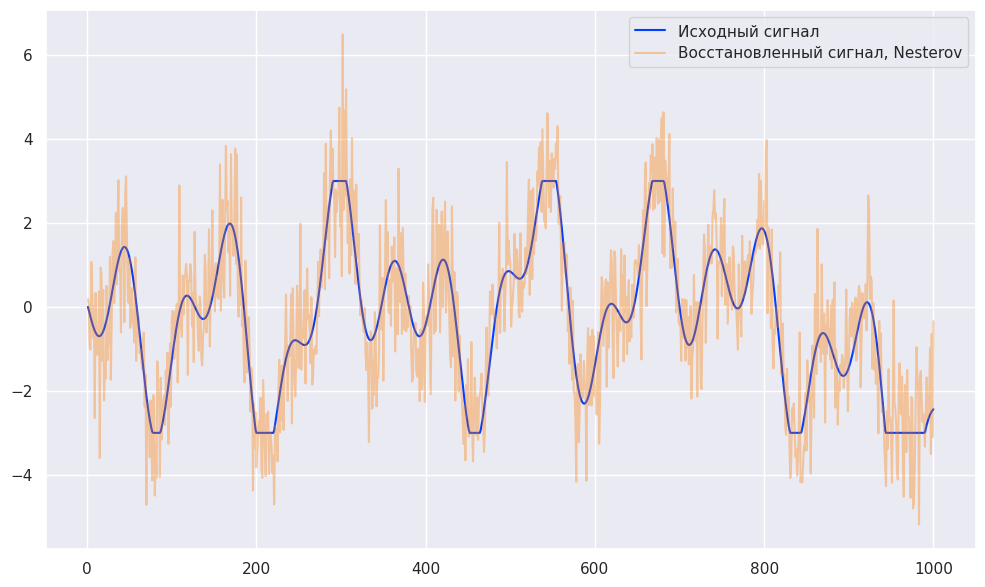

In [48]:
plt.figure(figsize=(12, 7))
plt.plot(np.arange(1, len(x_init) + 1), x_init, label='Исходный сигнал')
plt.plot(np.arange(1, len(x_init) + 1), signal[1], label='Восстановленный сигнал, Nesterov', alpha=0.35)
plt.legend();

Оба восстановленных сигнала практически неотличимы и, в целом, не так плохо приближают исходный сигнал.

## Задача 3. Свойства градиентных методов [5+3]

1. [1] Докажите, что градиенты, полученные на двух последовательных шагах градиентного спуска с использованием правила наискорейшего спуска, ортогональны.

2. [2] Докажите, что если целевая функция $f(x) = \frac{1}{2}x^{\top}Qx - b^{\top}x$, $Q \in \mathbb{S}^n_{++}$, шаг определяется с помощью наискорейшего спуска и $x^0 - x^*$ параллелен собственному вектору матрицы $Q$, то градиентный спуск сходится за один шаг. 

3. [2] Покажите, что сопряжённые направления являются линейно независимыми

4. [3*] Пусть $f$ имеет Липшицев градиент с константой $L$. Докажите, что условие достаточного убывания выполнено для шага $\alpha$ и направления убывания $\mathbf{h}$ в точке $\mathbf{x}$, если выполнено следующее условие:
$$0 < \alpha \leq \frac{\nabla f(\textbf{x})^\top  \mathbf{h}}{L\|\mathbf{h}\|_2^2}$$

### Решение задачи 3: 

1. БОО считаем, что переместились из начального состояния:
$$x_1 = x_0 + \alpha \nabla f(x_0)$$
Т.к. мы идём в направлении наискорейшего спуска, должно выполняться:
$$ \nabla_{\alpha} f(x_1) = 0 \\
\nabla_{\alpha} f(x_1) = \nabla f(x_1) ^T \frac{\partial x_1}{\partial \alpha} = \nabla f(x_1)^T \nabla f(x_0) = 0
$$ - что и хотели получить
2. Положим $r_0 = x^0 - x^*$ параллельно собственному вектору матрицы $Q$, $Ar_0 = \lambda r_0$Тогда 
$$
x^1 = x^0 + \frac{r_0^T r_0}{r_0^T Q r_0}(Ax_0 - b) = x^0 -\frac{r_0^T r_0}{\lambda r_0^T r_0}Qr_0 = x^0 -\frac{r_0^T r_0}{\lambda r_0^T r_0}(\lambda r_0) = x^0 - r_0 = x^*
$$ - что и хотели получить
3. Положим $d_1, ..., d_n$ - сопряжённые направления. Из сопряжённости относительно некоторой положительно определённой матрицы Q:
$$
(\sum\limits_{i=1}^n \alpha_i d_i)^T Q (\sum\limits_{i=1}^n \alpha_i d_i) = \sum\limits_{i=1}^n \alpha^2_i p_i^T A p_i = 0 \Rightarrow \alpha_i = 0 \, \forall i
$$ - что и хотели получить